In [26]:
import os
import glob
from datetime import datetime
from datetime import timezone
import polars as pl
import plotly.express as px

start_date = datetime(2023, 11, 17, 0, 0, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2023, 11, 30, 23, 59, 59).replace(tzinfo=timezone.utc)
id_system = 11

DATA_DIRECTORY = os.environ.get("DATA_DIRECTORY")
PICARRO_DATA_DIRECTORy = os.environ.get("PICARRO_DATA_DIRECTORY")

df_cal = pl.scan_parquet(os.path.join(DATA_DIRECTORY, "processed", "slope_intercept_acropolis.parquet"))

In [27]:
df_cal = df_cal.with_columns((pl.col("creation_timestamp").dt.timestamp("ms") / 3.6e6).alias("timestamp")) #3.6e6 ms are in 1h

#df_cal = df_cal.with_columns((pl.col("creation_timestamp").dt.timestamp().cast(pl.Float64)).alias("timestamp"))

In [28]:
df_sys = df_cal.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-{id_system}").filter(pl.col("creation_timestamp").is_between(start_date, end_date))

In [29]:
fig = px.line(df_sys.collect(), x="date", y=f"slope", markers=True, title = "Slope")
fig.show()

fig = px.line(df_sys.collect(), x="date", y=f"intercept", markers=True, title = "Slope")
fig.show()

# Define slope and intercept over time with linear regression

R-squared: 0.026502


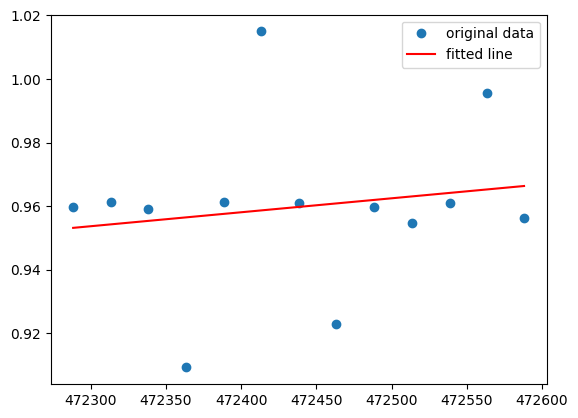

In [30]:
import numpy as np
from scipy import stats

y = df_sys.select(pl.col("slope")).collect().to_series().to_list()
x = df_sys.select(pl.col("timestamp")).collect().to_series().to_list()

x = np.array(x)
#x = range(len(y))

res = stats.linregress(x, y)

print(f"R-squared: {res.rvalue**2:.6f}")

import matplotlib.pyplot as plt
plt.plot(x, y, 'o', label='original data')
plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

R-squared: 0.030480


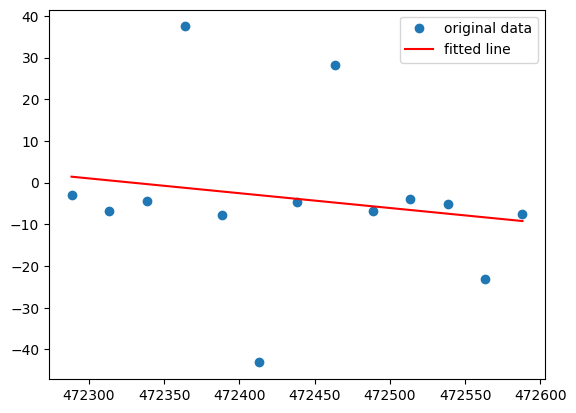

In [31]:
import numpy as np
from scipy import stats

y = df_sys.select(pl.col("intercept")).collect().to_series().to_list()
x = df_sys.select(pl.col("timestamp")).collect().to_series().to_list()

x = np.array(x)
#x = range(len(y))

res = stats.linregress(x, y)

print(f"R-squared: {res.rvalue**2:.6f}")

import matplotlib.pyplot as plt
plt.plot(x, y, 'o', label='original data')
plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

# Use RANSAC algortihm

Estimated coefficients (true, linear regression, RANSAC):
[4.39139774e-05] [-1.06729819e-05]
[ True  True  True False  True False  True False  True  True  True False
  True]


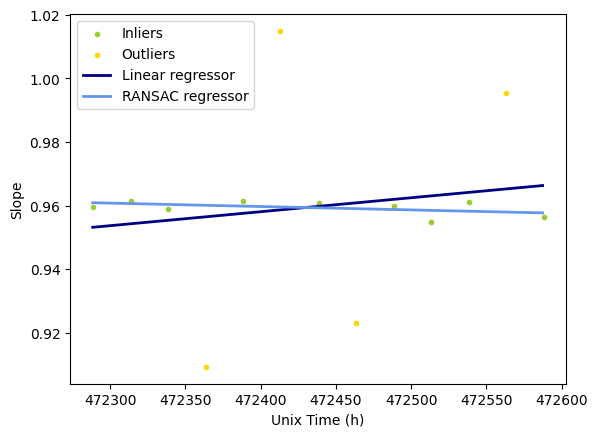

In [32]:
from sklearn import linear_model
import numpy as np

# ---- init ----

df_sys = df_cal.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-{id_system}").filter(pl.col("creation_timestamp").is_between(start_date, end_date))

y = df_sys.select(pl.col("slope")).collect().to_series().to_list()
x = df_sys.select(pl.col("timestamp")).collect().to_series().to_list()

#x = range(len(y))

Y = np.array(y)
X = np.array(x)

# --------------

lr = linear_model.LinearRegression()
lr.fit(X.reshape(-1, 1), Y)


# Robustly fit linear model with RANSAC algorithm
ransac_slope = linear_model.RANSACRegressor(residual_threshold=0.02)
ransac_slope.fit(X.reshape(-1, 1), Y)
inlier_mask = ransac_slope.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = lr.predict(line_X)
line_y_ransac = ransac_slope.predict(line_X)

# Compare estimated coefficients
print("Estimated coefficients (true, linear regression, RANSAC):")
print(lr.coef_, ransac_slope.estimator_.coef_)
print(inlier_mask)

lw = 2
#plt.gca().invert_yaxis() # Mirror points 

plt.scatter(
    X[inlier_mask], Y[inlier_mask], color="yellowgreen", marker=".", label="Inliers"
)
plt.scatter(
    X[outlier_mask], Y[outlier_mask], color="gold", marker=".", label="Outliers"
)
plt.plot(line_X, line_y, color="navy", linewidth=lw, label="Linear regressor")
plt.plot(
    line_X,
    line_y_ransac,
    color="cornflowerblue",
    linewidth=lw,
    label="RANSAC regressor",
)
plt.legend()
plt.xlabel("Unix Time (h)")
plt.ylabel("Slope")
plt.show()

Estimated coefficients (true, linear regression, RANSAC):
[-0.03551254] [-0.01239945]
[ True False  True False False False  True False  True False  True False
  True]


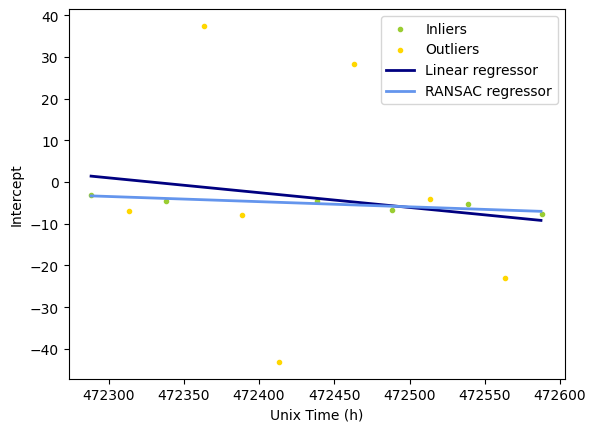

In [33]:
from sklearn import linear_model, datasets
import numpy as np

# ---- init ----

df_sys = df_cal.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-{id_system}").filter(pl.col("creation_timestamp").is_between(start_date, end_date))

y = df_sys.select(pl.col("intercept")).collect().to_series().to_list()
x = df_sys.select(pl.col("timestamp")).collect().to_series().to_list()

Y = np.array(y)
X = np.array(x)

# --------------

lr = linear_model.LinearRegression()
lr.fit(X.reshape(-1, 1), Y)


# Robustly fit linear model with RANSAC algorithm
ransac_intercept = linear_model.RANSACRegressor()
ransac_intercept.fit(X.reshape(-1, 1), Y)
inlier_mask = ransac_intercept.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = lr.predict(line_X)
line_y_ransac = ransac_intercept.predict(line_X)

# Compare estimated coefficients
print("Estimated coefficients (true, linear regression, RANSAC):")
print(lr.coef_, ransac_intercept.estimator_.coef_)
print(inlier_mask)

lw = 2
#plt.gca().invert_yaxis() # Mirror points 

plt.scatter(
    X[inlier_mask], Y[inlier_mask], color="yellowgreen", marker=".", label="Inliers"
)
plt.scatter(
    X[outlier_mask], Y[outlier_mask], color="gold", marker=".", label="Outliers"
)
plt.plot(line_X, line_y, color="navy", linewidth=lw, label="Linear regressor")
plt.plot(
    line_X,
    line_y_ransac,
    color="cornflowerblue",
    linewidth=lw,
    label="RANSAC regressor",
)
plt.legend()
plt.xlabel("Unix Time (h)")
plt.ylabel("Intercept")
plt.show()

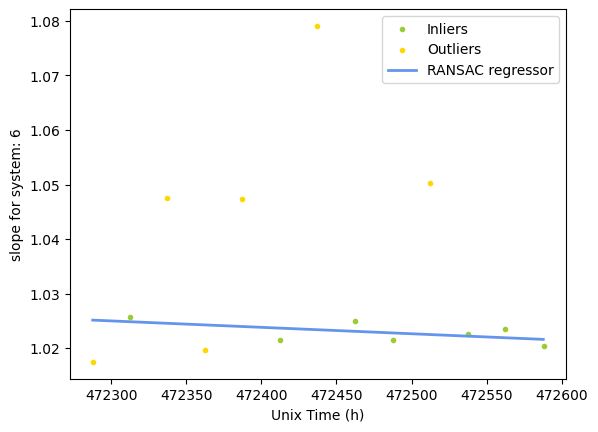

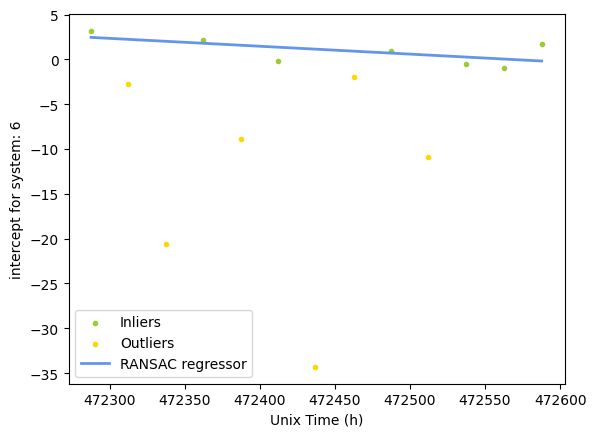

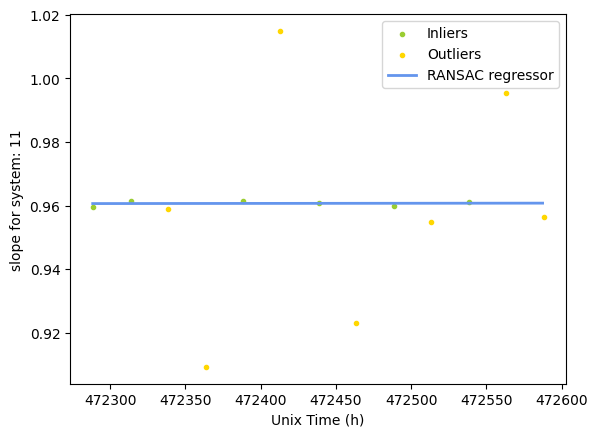

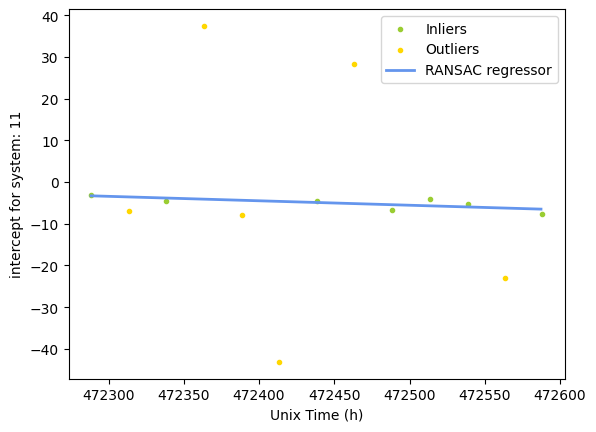

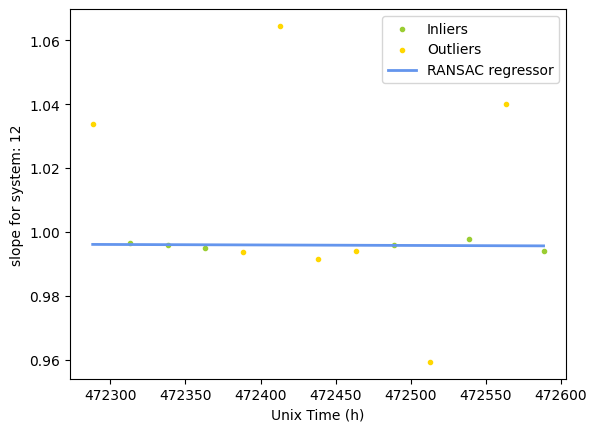

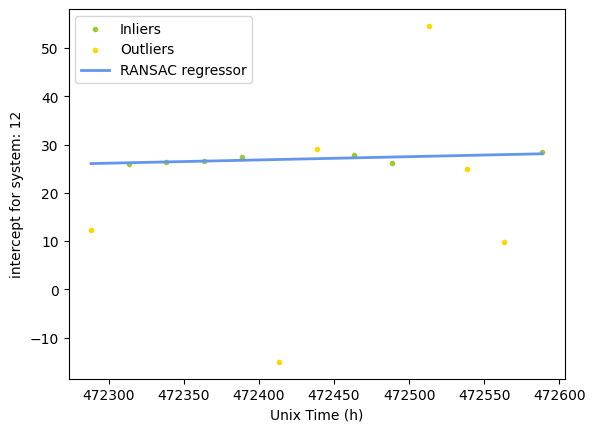

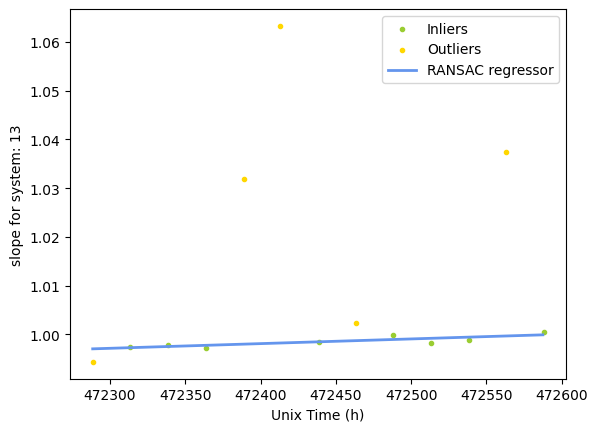

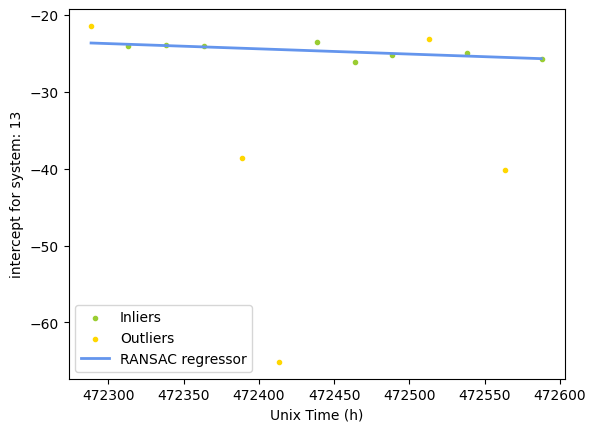

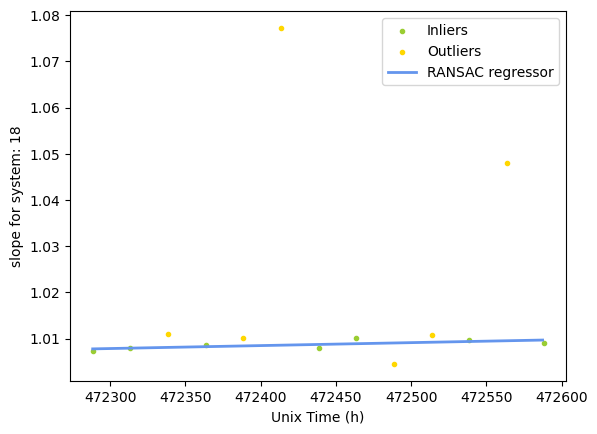

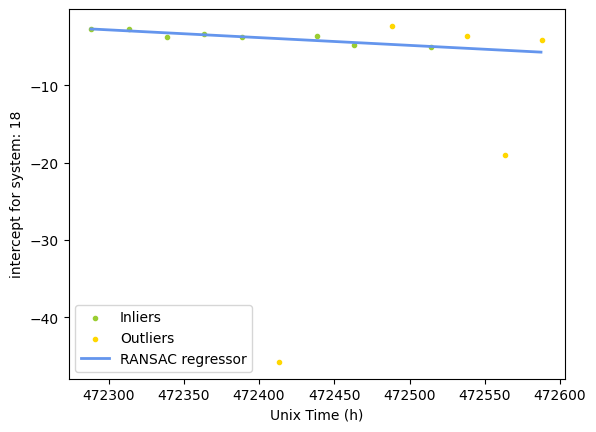

In [34]:
sensor_id = [6,11,12,13,18]

df_p_1h = pl.read_parquet(os.path.join(DATA_DIRECTORY,"processed", "1h_cal_corr_picarro.parquet")) \
    .filter(pl.col("creation_timestamp").is_between(start_date, end_date))

df_dry = pl.scan_parquet(os.path.join(DATA_DIRECTORY, "processed", "acropolis_dry.parquet")).filter(pl.col("creation_timestamp").is_between(start_date, end_date))

def calc_ransac(x, ransac):
    intercept = ransac.estimator_.intercept_
    slope = ransac.estimator_.coef_
    
    x = (x * slope) + intercept
    
    return x[0]

def fit_ransac(id_system, col):
    
    df_sys = df_cal.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-{id_system}").filter(pl.col("creation_timestamp").is_between(start_date, end_date))

    y = df_sys.select(pl.col(col)).collect().to_series().to_list()
    x = df_sys.select(pl.col("timestamp")).collect().to_series().to_list()

    #x = range(len(y))

    Y = np.array(y)
    X = np.array(x)

    # Robustly fit linear model with RANSAC algorithm
    ransac = linear_model.RANSACRegressor()
    ransac.fit(X.reshape(-1, 1), Y)
    inlier_mask = ransac.inlier_mask_
    outlier_mask = np.logical_not(inlier_mask)
    line_X = np.arange(X.min(), X.max())[:, np.newaxis]
    line_y_ransac = ransac.predict(line_X)
    
    lw = 2
    

    plt.scatter(
        X[inlier_mask], Y[inlier_mask], color="yellowgreen", marker=".", label="Inliers"
    )
    plt.scatter(
        X[outlier_mask], Y[outlier_mask], color="gold", marker=".", label="Outliers"
    )
    plt.plot(
        line_X,
        line_y_ransac,
        color="cornflowerblue",
        linewidth=lw,
        label="RANSAC regressor",
    )
    plt.legend()
    plt.xlabel("Unix Time (h)")
    plt.ylabel(f"{col} for system: {id}")
    plt.show()
    
    return ransac


l_df_cal_corr =[df_p_1h]
    

for id in sensor_id:  
    ransac_slope = fit_ransac(id, "slope")
    ransac_intercept = fit_ransac(id, "intercept")
    
    df_cal_corr = df_dry.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-{id}") \
        .with_columns((pl.col("creation_timestamp").dt.timestamp("ms") / 3.6e6).alias("unix_time_h")) \
        .with_columns((pl.col("unix_time_h").apply(lambda x: calc_ransac(x, ransac_slope))).alias("slope")) \
        .with_columns((pl.col("unix_time_h").apply(lambda x: calc_ransac(x, ransac_intercept))).alias("intercept")) \
        .with_columns((pl.col("gmp343_dry") * pl.col("slope") + pl.col("intercept")).alias("CO2_corr")) \
        .sort("creation_timestamp") \
        .select(["creation_timestamp", "system_name", "CO2_corr"]) \
        .groupby_dynamic("creation_timestamp", every='1h')  \
        .agg([
            pl.all().exclude(["creation_timestamp","system_name"]).mean(),
            pl.col("system_name")
            ]) \
        .with_columns(pl.col("system_name").list.last()) \
        .collect()
        
    df_cal_corr = df_cal_corr.join(df_p_1h.select("creation_timestamp", "CO2_corr") \
            .rename({"CO2_corr": "temp"}), on="creation_timestamp", how= "left") \
            .with_columns((pl.col("CO2_corr") - pl.col("temp")).alias("diff")) \
            .drop("temp")
        
    l_df_cal_corr.append(df_cal_corr)

In [35]:
df_cal_cor = pl.concat(l_df_cal_corr, how="diagonal")

In [36]:
import plotly.express as px

fig = px.line(df_cal_cor, x="creation_timestamp", y=f"CO2_corr", markers=True, title = "CO2", color="system_name")
fig.show()

fig = px.line(df_cal_cor, x="creation_timestamp", y=f"diff", markers=True, title = "CO2", color="system_name")
fig.show()

In [37]:
import math
from sklearn.metrics import r2_score

def rmse(y_true, y_meas):
    MSE = np.square(np.subtract(y_true, y_meas)).mean()
    RMSE = math.sqrt(MSE)

    return RMSE

def calc_r2(y_true, y_meas):
    return r2_score(y_true, y_meas)


for temp_id in sensor_id:

    print(f"\nAnalysis for System {temp_id}:")

    #----
    df_acropolis = df_cal_cor.filter(pl.col("system_name")==f"tum-esm-midcost-raspi-{temp_id}") \
        .select(["creation_timestamp", "CO2_corr"]) \
        .rename({"CO2_corr": f"CO2_acropolis_{temp_id}"})
        
    df_picarro = df_cal_cor.filter(pl.col("system_name")=="Picarro") \
        .select(["creation_timestamp", "CO2_corr"]) \
        .rename({"CO2_corr": f"CO2_picarro"})
        
    df_analysis = df_picarro.join(df_acropolis, on="creation_timestamp")  \
        .filter(pl.col("CO2_picarro") > 0)  \
        .filter(pl.col(f"CO2_acropolis_{temp_id}") > 0)
        
    l_picarro = df_analysis.select("CO2_picarro").to_series().to_list()
    l_acropolis = df_analysis.select(f"CO2_acropolis_{temp_id}").to_series().to_list()
    
    #----
    if len(l_acropolis) > 0:
        
        mean_offset = df_cal_cor.filter(pl.col("system_name")==f"tum-esm-midcost-raspi-{temp_id}").select("diff").mean().item()
        print(f"Offset {mean_offset}")
        
        rmse_result = rmse(l_picarro,l_acropolis)
        print(f"RMSE: {rmse_result}")
        
        r2_result = calc_r2(l_picarro,l_acropolis)
        print(f"R2: {r2_result}")


Analysis for System 6:
Offset 2.3321251012707234
RMSE: 4.126578437514063
R2: 0.7940610140696331

Analysis for System 11:
Offset 9.840893104481403
RMSE: 9.949513383433166
R2: -0.19718713673444221

Analysis for System 12:
Offset 12.26311814207832
RMSE: 12.285242219791886
R2: -0.8252645033690664

Analysis for System 13:
Offset -0.3577215958084975
RMSE: 1.0782822514345218
R2: 0.9859387712216033

Analysis for System 18:
Offset 0.7194449355178111
RMSE: 1.0118072807387095
R2: 0.9876190502444038


In [38]:
for temp_id in sensor_id:

    print(f"\nAnalysis for System {temp_id}:")

    #----
    mean_offset = 0
    if len(l_acropolis) > 0:
        mean_offset = df_cal_cor.filter(pl.col("system_name")==f"tum-esm-midcost-raspi-{temp_id}").select("diff").mean().item()
    
    df_acropolis = df_cal_cor.filter(pl.col("system_name")==f"tum-esm-midcost-raspi-{temp_id}") \
        .select(["creation_timestamp", "CO2_corr"]) \
        .with_columns(pl.col("CO2_corr") - mean_offset)  \
        .rename({"CO2_corr": f"CO2_acropolis_{temp_id}"})
        
    df_picarro = df_cal_cor.filter(pl.col("system_name")=="Picarro") \
        .select(["creation_timestamp", "CO2_corr"]) \
        .rename({"CO2_corr": f"CO2_picarro"})
        
    df_analysis = df_picarro.join(df_acropolis, on="creation_timestamp")  \
        .filter(pl.col("CO2_picarro") > 0)  \
        .filter(pl.col(f"CO2_acropolis_{temp_id}") > 0)
        
    l_picarro = df_analysis.select("CO2_picarro").to_series().to_list()
    l_acropolis = df_analysis.select(f"CO2_acropolis_{temp_id}").to_series().to_list()
    
    #----
    if len(l_acropolis) > 0:
        
        rmse_result = rmse(l_picarro,l_acropolis)
        print(f"RMSE: {rmse_result}")
        
        r2_result = calc_r2(l_picarro,l_acropolis)
        print(f"R2: {r2_result}")


Analysis for System 6:
RMSE: 3.4043857174208423
R2: 0.8598361944269519

Analysis for System 11:
RMSE: 1.4661648861182244
R2: 0.9740029548074343

Analysis for System 12:
RMSE: 0.7369598580565194
R2: 0.9934318051782423

Analysis for System 13:
RMSE: 1.0172157458724886
R2: 0.9874863354401519

Analysis for System 18:
RMSE: 0.7114442761830573
R2: 0.9938787496740948


# Perform RANSAC only on slope and then select valid calibrations

In [65]:
sensor_id = [6,11,12,13,18]


df_p_1h = pl.read_parquet(os.path.join(DATA_DIRECTORY,"processed", "1h_cal_corr_picarro.parquet")) \
    .filter(pl.col("creation_timestamp").is_between(start_date, end_date))

df_dry = pl.scan_parquet(os.path.join(DATA_DIRECTORY, "processed", "acropolis_dry.parquet")).filter(pl.col("creation_timestamp").is_between(start_date, end_date))


def fit_ransac(x, y):
    #x = range(len(y))

    Y = np.array(y)
    X = np.array(x)

    # Robustly fit linear model with RANSAC algorithm
    ransac = linear_model.RANSACRegressor(residual_threshold=0.01)
    ransac.fit(X.reshape(-1, 1), Y)
    inlier_mask = ransac.inlier_mask_
    outlier_mask = np.logical_not(inlier_mask)
    line_X = np.arange(X.min(), X.max())[:, np.newaxis]
    line_y_ransac = ransac.predict(line_X)
    
    # plot
    lw = 2
    
    plt.scatter(
        X[inlier_mask], Y[inlier_mask], color="yellowgreen", marker=".", label="Inliers"
    )
    plt.scatter(
        X[outlier_mask], Y[outlier_mask], color="gold", marker=".", label="Outliers"
    )
    plt.plot(
        line_X,
        line_y_ransac,
        color="cornflowerblue",
        linewidth=lw,
        label="RANSAC regressor",
    )
    plt.legend()
    plt.xlabel("Unix Time (h)")
    plt.ylabel(f"slope for system: {id}")
    plt.show()
    #----
    
    return inlier_mask

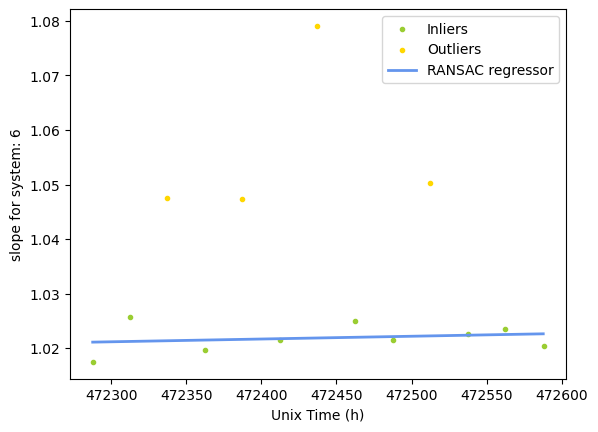

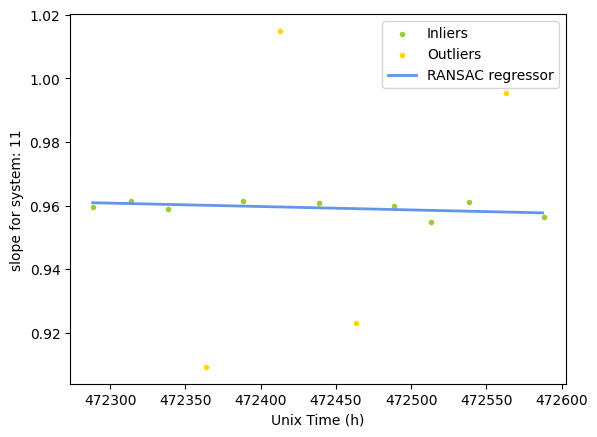

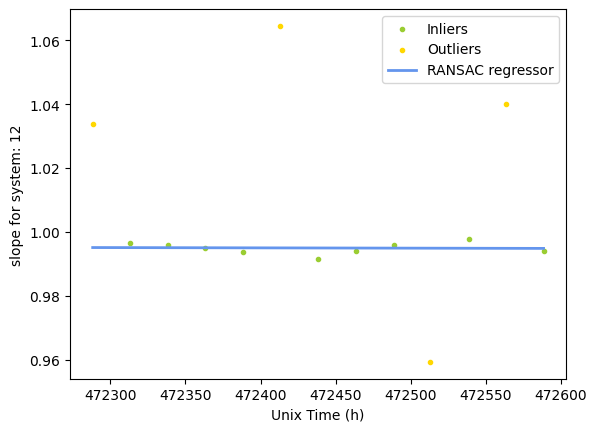

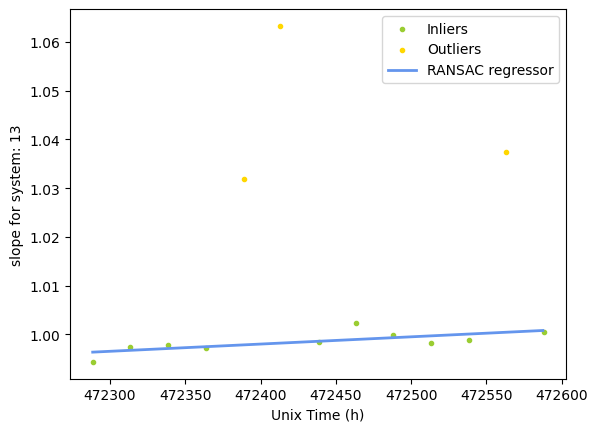

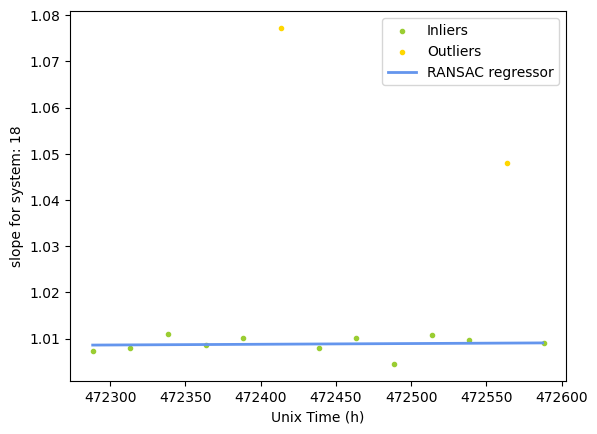

In [77]:
l_df_cor = []

for id in sensor_id:
    df_sys = df_cal.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-{id}").filter(pl.col("creation_timestamp").is_between(start_date, end_date))

    y = df_sys.select(pl.col("slope")).collect().to_series().to_list()
    x = df_sys.select(pl.col("timestamp")).collect().to_series().to_list()

    mask = fit_ransac(x,y)

    df_sys = df_sys.with_columns(mask = pl.Series(mask)).collect()
    
    l_df_cor.append(df_sys)
    

df_cal_ransac = pl.concat(l_df_cor, how="diagonal")

In [80]:
df_cal_ransac.with_columns((pl.col("slope") * pl.col("mask")).alias("ransac_slope")) \
    .with_columns((pl.col("intercept") * pl.col("mask")).alias("ransac_intercept")) \
    .sort("creation_timestamp")

date,system_name,slope,intercept,creation_timestamp,timestamp,mask,ransac_slope,ransac_intercept
date,str,f64,f64,"datetime[μs, UTC]",f64,bool,f64,f64
2023-11-17,"""tum-esm-midcos…",1.017459,3.179986,2023-11-17 15:40:37.240 UTC,472287.677011,true,1.017459,3.179986
2023-11-17,"""tum-esm-midcos…",1.033872,12.283321,2023-11-17 16:20:28.940 UTC,472288.341372,false,0.0,0.0
2023-11-17,"""tum-esm-midcos…",0.959702,-3.040169,2023-11-17 16:21:52.750 UTC,472288.364653,true,0.959702,-3.040169
2023-11-17,"""tum-esm-midcos…",1.007333,-2.684493,2023-11-17 16:21:58.570 UTC,472288.366269,true,1.007333,-2.684493
2023-11-17,"""tum-esm-midcos…",0.994368,-21.432702,2023-11-17 16:32:03.230 UTC,472288.534231,true,0.994368,-21.432702
2023-11-18,"""tum-esm-midcos…",1.025614,-2.790901,2023-11-18 16:30:31.690 UTC,472312.508803,true,1.025614,-2.790901
2023-11-18,"""tum-esm-midcos…",0.996675,25.975735,2023-11-18 17:20:13.390 UTC,472313.337053,true,0.996675,25.975735
2023-11-18,"""tum-esm-midcos…",1.007969,-2.720457,2023-11-18 17:20:15.250 UTC,472313.337569,true,1.007969,-2.720457
2023-11-18,"""tum-esm-midcos…",0.997453,-24.014836,2023-11-18 17:20:20.540 UTC,472313.339039,true,0.997453,-24.014836
